In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU, LSTM, Conv1D, Conv2D
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [3]:
def retrieve_data(varname, filename):
#     df = pd.read_csv(filename, index_col=0)
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback, features=[]):
    rows = []
    
    if features != []:
        df = df[features].copy()
    columns = ['Date', 'SP500_relative_change_perc_1'] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist()[1:] # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist()[1:] # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    df2 = pd.DataFrame(rows)
    df2.columns = columns
    return df2

def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        # assumes years_train < year_val < year_test
        df["Date"] = pd.to_datetime(df["Date"])
        
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year < year_val]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = df.head(len(val) - len(test))
    y_train = train['SP500_relative_change_perc_1']
    x_train = train.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_val = val['SP500_relative_change_perc_1']
    x_val = val.drop(['SP500_relative_change_perc_1'], axis=1)
    
    y_test = test['SP500_relative_change_perc_1']
    x_test = test.drop(['SP500_relative_change_perc_1'], axis=1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x = x.drop(["Date"], axis=1)
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

In [6]:
lookback = 3
val_year = 2018
test_year = 2019

files = {
    # varname: filename
    "S&P500": "Dataset v3/SP500_reduced_data_20220425.csv",
#     "S&P500": "Dataset v3/SP500_combined_data_20220422.csv"
}

for file in files:
    df = retrieve_data(file, files[file])
print(df.columns.tolist())
# df = create_classification_data(df, lookback)

# x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(df, val_year, test_year)

['Unnamed: 0', 'Date', 'SP500_relative_change_perc_1', 'SP500_F_relative_change_perc_1', 'Gold_F_relative_change_perc_1', 'Silver_F_relative_change_perc_1', 'Copper_F_relative_change_perc_1', 'SP500_williams_R_5', 'SP500_williams_R_10', 'SP500_williams_R_20', 'SP500_williams_R_50', 'SP500_AD_MACD_12_26', 'SP500_stochastic_D_5_5', 'SP500_momentum_8', 'SP500_momentum_16', 'SP500_AD_oscillator', 'SP500_stochastic_K_5', 'SP500_stochastic_K_10', 'SP500_stochastic_K_20', 'SP500_stochastic_K_50']


In [8]:
y_train

0       575930000.0
1       343150000.0
2       445270000.0
3       483770000.0
4       347500000.0
5       485580000.0
6       393570000.0
7       602150000.0
8       735530000.0
9       874780000.0
10      874100000.0
11      526960000.0
12      438360000.0
13      433310000.0
14      363550000.0
15      382430000.0
16      469600000.0
17      422690000.0
18      394240000.0
19      395810000.0
20      423180000.0
21      341770000.0
22      387480000.0
23      300440000.0
24      355490000.0
25      445070000.0
26      440160000.0
27      306050000.0
28      524380000.0
29      431150000.0
           ...     
2107     94550000.0
2108     87600000.0
2109     65050000.0
2110    100530000.0
2111    102360000.0
2112     56110000.0
2113     82870000.0
2114    105720000.0
2115    166670000.0
2116    166110000.0
2117    159040000.0
2118    130170000.0
2119    109400000.0
2120    114240000.0
2121    102690000.0
2122     93420000.0
2123    141100000.0
2124     77640000.0
2125     95270000.0


In [29]:
def label_data(y):
    positives = []
    negatives = []
    y = list(y)
#     for dev in y:
#         if dev >= 0:
#             positives.append(dev)
#         else:
#             negatives.append(dev)
#     med_pos = median(positives)
#     med_neg = median(negatives)
    
    labels = []
    for dev in y:
        if dev >= 0:
            labels.append(1)
#             if dev >= med_pos:
#                 labels.append(2)
#             else:
#                 labels.append(1)
        else:
            labels.append(0)
#             if dev <= med_neg:
#                 labels.append(-2)
#             else:
#                 labels.append(-1)
    return labels
# 
y_train = label_data(y_train)
y_val = label_data(y_val)
y_test = label_data(y_test)

In [30]:
def random_baseline(y):
    counts = [0, 0]
    for i in y:
        if i == 0:
            counts[0] = counts[0] + 1
        elif i == 1:
            counts[1] = counts[1] + 1
    print(f"\tDistribution: {counts}")
    print(f"\tRandom baseline accuracy (majority class): {counts[np.argmax(np.asarray(counts))]/ len(y)}")
    
print("Random baseline training set")
random_baseline(y_train)
print("Random baseline validation set")
random_baseline(y_val)
print("Random baseline test set")
random_baseline(y_val)

Random baseline training set
	Distribution: [0, 2126]
	Random baseline accuracy (majority class): 1.0
Random baseline validation set
	Distribution: [0, 251]
	Random baseline accuracy (majority class): 1.0
Random baseline test set
	Distribution: [0, 251]
	Random baseline accuracy (majority class): 1.0


In [31]:
train_date = x_train[['Date']]
x_train = x_train.drop(['Date'], axis=1)

val_date = x_val[['Date']]
x_val = x_val.drop(['Date'], axis=1)

test_date = x_test[['Date']]
x_test = x_test.drop(['Date'], axis=1)

In [32]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

print(x_train.shape, y_train.shape)

(2126, 4200) (2126,)


In [33]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# y_train = to_categorical(y_train, 1)
# y_val = to_categorical(y_val, 1)
# y_test = to_categorical(y_test, 1)

y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [34]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(2126, 1, 4200) (2126, 1)
(251, 1, 4200) (251, 1)
(252, 1, 4200) (252, 1)


In [36]:
# epochs = 500
# batch_size = 512

# model = Sequential()
# model.add(LSTM(90, dropout=0.2, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(Dense(100, activation='sigmoid'))
# model.add(Dense(40, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

## RESULT OPTIMIZATION 1
# epochs = 330
# batch_size = 128
# model = Sequential()
# model.add(LSTM(26, dropout=0.6, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(LSTM(6, dropout=0.38, return_sequences=True))
# model.add(Dense(95, activation='sigmoid'))
# model.add(Dense(74, activation='sigmoid'))
# model.add(Dense(4, activation='softmax'))

## RESULT OPTIMIZATION 2
# epochs = 95
# batch_size = 256
# model = Sequential()
# model.add(LSTM(66, dropout=0.41, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(LSTM(128, dropout=0.31, return_sequences=True))
# model.add(Dense(130, activation='sigmoid'))
# model.add(Dense(28, activation='sigmoid'))
# model.add(Dense(4, activation='softmax'))

# RESULT OPTIMIZATION 3
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)

# epochs = 491
# batch_size = 64
# model = Sequential()
# model.add(LSTM(109, dropout=0.28, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(LSTM(329, dropout=0.16, return_sequences=True))
# model.add(Dense(66, activation='tanh'))
# model.add(Dense(158, activation='tanh'))
# model.add(Dense(1, activation='sigmoid'))

tensorflow.random.set_seed(111)
np.random.seed(111)
random.seed(111)

epochs = 474
batch_size = 64
model = Sequential()
model.add(LSTM(322, dropout=0.89, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(61, dropout=0.79, return_sequences=True))
model.add(Dense(262, activation='sigmoid'))
model.add(Dense(282, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

Epoch 1/474
34/34 [==============================] - 11s 106ms/step - loss: 0.1811 - acc: 0.8815 - val_loss: 4.6244e-04 - val_acc: 1.0000
Epoch 2/474
34/34 [==============================] - 2s 52ms/step - loss: 4.1337e-04 - acc: 1.0000 - val_loss: 3.3251e-04 - val_acc: 1.0000
Epoch 3/474
34/34 [==============================] - 2s 52ms/step - loss: 3.3320e-04 - acc: 1.0000 - val_loss: 3.0434e-04 - val_acc: 1.0000
Epoch 4/474
34/34 [==============================] - 2s 51ms/step - loss: 3.0718e-04 - acc: 1.0000 - val_loss: 2.7886e-04 - val_acc: 1.0000
Epoch 5/474
34/34 [==============================] - 2s 54ms/step - loss: 2.8242e-04 - acc: 1.0000 - val_loss: 2.5425e-04 - val_acc: 1.0000
Epoch 6/474
34/34 [==============================] - 2s 53ms/step - loss: 2.5856e-04 - acc: 1.0000 - val_loss: 2.3102e-04 - val_acc: 1.0000
Epoch 7/474
34/34 [==============================] - 2s 52ms/step - loss: 2.3630e-04 - acc: 1.0000 - val_loss: 2.0938e-04 - val_acc: 1.0000
Epoch 8/474
34/34 [===

34/34 [==============================] - 2s 53ms/step - loss: 3.6235e-06 - acc: 1.0000 - val_loss: 2.2462e-06 - val_acc: 1.0000
Epoch 118/474
34/34 [==============================] - 2s 52ms/step - loss: 3.4969e-06 - acc: 1.0000 - val_loss: 2.2099e-06 - val_acc: 1.0000
Epoch 119/474
34/34 [==============================] - 2s 52ms/step - loss: 3.5957e-06 - acc: 1.0000 - val_loss: 2.1743e-06 - val_acc: 1.0000
Epoch 120/474
34/34 [==============================] - 2s 54ms/step - loss: 3.4491e-06 - acc: 1.0000 - val_loss: 2.1322e-06 - val_acc: 1.0000
Epoch 121/474
34/34 [==============================] - 2s 53ms/step - loss: 3.5234e-06 - acc: 1.0000 - val_loss: 2.0876e-06 - val_acc: 1.0000
Epoch 122/474
34/34 [==============================] - 2s 53ms/step - loss: 3.4341e-06 - acc: 1.0000 - val_loss: 2.0617e-06 - val_acc: 1.0000
Epoch 123/474
34/34 [==============================] - 2s 52ms/step - loss: 3.2188e-06 - acc: 1.0000 - val_loss: 2.0320e-06 - val_acc: 1.0000
Epoch 124/474
34/34 

Epoch 175/474
34/34 [==============================] - 2s 51ms/step - loss: 1.3289e-06 - acc: 1.0000 - val_loss: 8.9217e-07 - val_acc: 1.0000
Epoch 176/474
34/34 [==============================] - 2s 54ms/step - loss: 1.3456e-06 - acc: 1.0000 - val_loss: 8.7911e-07 - val_acc: 1.0000
Epoch 177/474
34/34 [==============================] - 2s 51ms/step - loss: 1.2932e-06 - acc: 1.0000 - val_loss: 8.6985e-07 - val_acc: 1.0000
Epoch 178/474
34/34 [==============================] - 2s 53ms/step - loss: 1.2880e-06 - acc: 1.0000 - val_loss: 8.5655e-07 - val_acc: 1.0000
Epoch 179/474
34/34 [==============================] - 2s 53ms/step - loss: 1.2635e-06 - acc: 1.0000 - val_loss: 8.3518e-07 - val_acc: 1.0000
Epoch 180/474
34/34 [==============================] - 2s 53ms/step - loss: 1.2524e-06 - acc: 1.0000 - val_loss: 8.2710e-07 - val_acc: 1.0000
Epoch 181/474
34/34 [==============================] - 2s 53ms/step - loss: 1.1955e-06 - acc: 1.0000 - val_loss: 8.0858e-07 - val_acc: 1.0000
Epoch 

Epoch 233/474
34/34 [==============================] - 2s 52ms/step - loss: 4.7563e-07 - acc: 1.0000 - val_loss: 3.4101e-07 - val_acc: 1.0000
Epoch 234/474
34/34 [==============================] - 2s 54ms/step - loss: 4.9221e-07 - acc: 1.0000 - val_loss: 3.1037e-07 - val_acc: 1.0000
Epoch 235/474
34/34 [==============================] - 2s 54ms/step - loss: 4.6666e-07 - acc: 1.0000 - val_loss: 2.8971e-07 - val_acc: 1.0000
Epoch 236/474
34/34 [==============================] - 2s 53ms/step - loss: 4.5462e-07 - acc: 1.0000 - val_loss: 2.8781e-07 - val_acc: 1.0000
Epoch 237/474
34/34 [==============================] - 2s 53ms/step - loss: 4.2936e-07 - acc: 1.0000 - val_loss: 2.8021e-07 - val_acc: 1.0000
Epoch 238/474
34/34 [==============================] - 2s 52ms/step - loss: 4.4473e-07 - acc: 1.0000 - val_loss: 2.7974e-07 - val_acc: 1.0000
Epoch 239/474
34/34 [==============================] - 2s 51ms/step - loss: 4.2787e-07 - acc: 1.0000 - val_loss: 2.7855e-07 - val_acc: 1.0000
Epoch 

Epoch 291/474
34/34 [==============================] - 2s 57ms/step - loss: 1.3501e-07 - acc: 1.0000 - val_loss: 7.9315e-08 - val_acc: 1.0000
Epoch 292/474
34/34 [==============================] - 2s 57ms/step - loss: 1.2913e-07 - acc: 1.0000 - val_loss: 7.4565e-08 - val_acc: 1.0000
Epoch 293/474
34/34 [==============================] - 2s 56ms/step - loss: 1.2974e-07 - acc: 1.0000 - val_loss: 7.1716e-08 - val_acc: 1.0000
Epoch 294/474
34/34 [==============================] - 2s 55ms/step - loss: 1.1905e-07 - acc: 1.0000 - val_loss: 4.6544e-08 - val_acc: 1.0000
Epoch 295/474
34/34 [==============================] - 2s 54ms/step - loss: 1.1906e-07 - acc: 1.0000 - val_loss: 3.9182e-08 - val_acc: 1.0000
Epoch 296/474
34/34 [==============================] - 2s 53ms/step - loss: 1.1470e-07 - acc: 1.0000 - val_loss: 3.6570e-08 - val_acc: 1.0000
Epoch 297/474
34/34 [==============================] - 2s 59ms/step - loss: 1.0491e-07 - acc: 1.0000 - val_loss: 2.3509e-08 - val_acc: 1.0000
Epoch 

Epoch 349/474
34/34 [==============================] - 2s 46ms/step - loss: 1.9799e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 350/474
34/34 [==============================] - 2s 47ms/step - loss: 1.4870e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 351/474
34/34 [==============================] - 2s 50ms/step - loss: 1.9231e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 352/474
34/34 [==============================] - 2s 51ms/step - loss: 1.5760e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 353/474
34/34 [==============================] - 2s 52ms/step - loss: 1.2993e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 354/474
34/34 [==============================] - 2s 56ms/step - loss: 1.2995e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 355/474
34/34 [==============================] - 2s 57ms/step - loss: 1.5710e-08 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 

Epoch 407/474
34/34 [==============================] - 2s 47ms/step - loss: 4.8710e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 408/474
34/34 [==============================] - 2s 45ms/step - loss: 3.2479e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 409/474
34/34 [==============================] - 2s 45ms/step - loss: 6.9433e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 410/474
34/34 [==============================] - 2s 45ms/step - loss: 4.6508e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 411/474
34/34 [==============================] - 2s 45ms/step - loss: 5.5792e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 412/474
34/34 [==============================] - 2s 45ms/step - loss: 5.0957e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 413/474
34/34 [==============================] - 1s 44ms/step - loss: 5.4109e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 

Epoch 465/474
34/34 [==============================] - 2s 50ms/step - loss: 1.7688e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 466/474
34/34 [==============================] - 2s 46ms/step - loss: 1.8537e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 467/474
34/34 [==============================] - 2s 51ms/step - loss: 2.7570e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 468/474
34/34 [==============================] - 2s 52ms/step - loss: 1.7683e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 469/474
34/34 [==============================] - 2s 53ms/step - loss: 3.1039e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 470/474
34/34 [==============================] - 2s 60ms/step - loss: 1.5430e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 471/474
34/34 [==============================] - 2s 55ms/step - loss: 1.9164e-09 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 

In [37]:
def evaluate_convergence(history):
    epochs = []
    for i in range(len(history.history['loss'])):
        epochs.append(i)
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=epochs, y=train_loss, mode="lines", name="Train Loss"), row=1, col=1)
    fig1.add_trace(go.Scatter(x=epochs, y=val_loss, mode="lines", name="Validation Loss"), row=1, col=1)
    fig1.update_layout(
        title = "Training and Validation Loss Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Loss"),
    )
#     fig1.write_image()
    fig1.show()
    
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    fig2 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig2.add_trace(go.Scatter(x=epochs, y=train_acc, mode="lines", name="Training Accuracy"), row=1, col=1)
    fig2.add_trace(go.Scatter(x=epochs, y=val_acc, mode="lines", name="Validation Accuracy"), row=1, col=1)
    fig2.update_layout(
        title = "Training and Validation Accuracy Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Accuracy"),
    )
#     fig2.write_image()
    fig2.show()
    
evaluate_convergence(history)

In [38]:
def evaluate(model, x, y):
    y = y.tolist()
    y_pred = model.predict(x)
    y_pred = y_pred.round()
    y_pred = y_pred.tolist()
    
    for i in range(len(y)):
        y[i] = int(y[i][0])
        y_pred[i] = int(y_pred[i][0][0])
    
    acc = accuracy(y, y_pred)
    print(f"\tAccuracy: {acc}")
    
    prec = precision(y, y_pred)
    print(f"\tPrecision: {prec}")
    
    rec = recall(y, y_pred)
    print(f"\tRecall: {rec}")
    
    f = f1(y, y_pred)
    print(f"\tF1-score: {f}")
    
print("Training set evaluation")
evaluate(model, x_train, y_train)
print("Validation set evaluation")
evaluate(model, x_val, y_val)
# print("Test set evaluation")
# evaluate(model, x_test, y_test)

Training set evaluation
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0
Validation set evaluation
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-score: 1.0


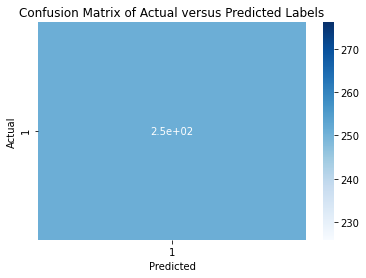

In [39]:
def confusion_matrix(model, x, y):
    y_pred = model.predict(x, batch_size=1)

    originals = []
    predictions = []

    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))
        
    df = pd.DataFrame()
    df['Actual'] = originals
    df['Predicted'] = predictions
    
    conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    plt.title("Confusion Matrix of Actual versus Predicted Labels")
    plt.show()
    
# confusion_matrix(model, x_train, y_train)
confusion_matrix(model, x_val, y_val)

In [22]:
def retrieve_candles(filename, val_year, test_year):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.columns = ["Date", "Close", "Open", "High", "Low", "Vol.", "Change%"]
    df = df.sort_values('Date', ascending=True)
    
    candles_val = df[df['Date'].dt.year == val_year]
    candles_train = df[df['Date'].dt.year < val_year]
    candles_train = candles_train[candles_train['Date'] > datetime(2009,7,10)]
    
    candles_train = candles_train.replace(',','', regex=True)
    candles_val = candles_val.replace(',','', regex=True)

    return candles_train, candles_val

def plot_predictions_candles(x, y, df, dataset):
    # PREDICTIONS LIJKEN NOG NIET GOED UITGELIJND MET CANDLES???
    originals = []
    predictions = []
    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        originals.append(np.argmax(y[i]))
        predictions.append(np.argmax(y_pred[i]))
    
    for i in range(len(originals)):
        if originals[i] == 0:
            originals[i] = -2
        elif originals[i] == 1:
            originals[i] = -1
        elif originals[i] == 2:
            originals[i] = 1
        elif originals[i] == 3:
            originals[i] = 2
        
        if predictions[i] == 0:
            predictions[i] = -2
        elif predictions[i] == 1:
            predictions[i] = -1
        elif predictions[i] == 2:
            predictions[i] = 1
        elif predictions[i] == 3:
            predictions[i] = 2

    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name="Price"))
    standard_factor = 0.5 * mean([float(df.iloc[0].tolist()[3]), float(df.iloc[0].tolist()[4])])
    
    green_legend = False
    orange_legend = False
    red_legend = False
    
    for i, row in enumerate(df.iterrows()):
        pred_date = row[1][0].to_pydatetime()
        pred_high = float(row[1][3])
        pred_low = float(row[1][4])
#         real_label = row[1][7]
#         pred_label = row[1][8]
        real_label = originals[i]
        pred_label = predictions[i]
        
        start_shape = pred_date - timedelta(days=0.1)
        end_shape = pred_date + timedelta(days=0.1)
        
        if pred_label == 1:
            extreme = pred_high + 0.1 * standard_factor
            standard = pred_high + 0.05 * standard_factor
        elif pred_label == 2:
            extreme = pred_high + 0.2 * standard_factor
            standard = pred_high + 0.05 * standard_factor
        elif pred_label == -1:
            extreme = pred_low - 0.1 * standard_factor
            standard = pred_low -  0.05 * standard_factor
        elif pred_label == -2:
            extreme = pred_low - 0.2 * standard_factor
            standard = pred_low - 0.05 * standard_factor
            
        if real_label == pred_label:
            color = "green"
        elif np.sign(real_label) == np.sign(pred_label):
            color = "orange"
        else:
            color = "red"
        
        if real_label == pred_label and not green_legend:
            green_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction / Correct Magnitude", mode="lines", line=dict(color=color)))
        elif np.sign(real_label) == np.sign(pred_label) and not orange_legend:
            orange_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction / Inorrect Magnitude", mode="lines", line=dict(color=color)))
        elif np.sign(real_label) != np.sign(pred_label) and not red_legend:
            red_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Incorrect Direction", mode="lines", line=dict(color=color)))
        else:
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", showlegend=False, mode="lines", line=dict(color=color)))
    
    title = f"Visualization of {dataset} Predictions"
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    layout = dict(title=title, height=800, width=1500)
    fig.update_layout(layout)
#     config = dict({'scrollZoom': True})
#     fig.show(config=config)
    fig.show()

filename = "Dataset v3/Indices/S&P 500 Historical Data.csv"
candles_train, candles_val = retrieve_candles(filename, val_year, test_year) 
plot_predictions_candles(x_train, y_train, candles_train, "Training")
plot_predictions_candles(x_val, y_val, candles_val, "Validation")

IndexError: list index out of range